<a href="https://colab.research.google.com/github/harishkollana/Topic-Modeling-on-News-Articles-Clustering/blob/main/Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

# **Import Libraries**

In [215]:
#import libraries for topic modeling on news articles
import numpy as np
import pandas as pd
import scipy.stats as stats
import json
import glob


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#spacy for lemmatization
import spacy
import glob
import string
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
!pip install pyLDAvis==3.2.1
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [216]:
!pip install spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 881 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [217]:
#!pip install -U pandas-profiling

# **Import Data**

In [218]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [219]:
#load path to data
path = '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc'

In [220]:
#Importing text file paths
business = glob.glob(path+'/business/*')
entertainment = glob.glob(path+'/entertainment/*')
politics = glob.glob(path+'/politics/*')
sports = glob.glob(path+'/sport/*')
tech = glob.glob(path+'/tech/*')

In [221]:
business[0:5]

['/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/507.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/505.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/471.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/498.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/510.txt']

In [222]:
# Making the data lists for different topics.
def make_list(data):
    list = []
    for i in range(len(data)):
      file = open(data[i],'r')
      list.append(file.read())
    return(list)

In [223]:
sports_text=[]

for i in range(len(sports)):
  f=open(sports[i],errors='ignore')
  a=f.read()
  sports_text.append(a)

In [224]:
sports_text[0]

'Henman to face Saulnier test\n\nBritish number one Tim Henman will face France\'s Cyril Saulnier in the first round of next week\'s Australian Open.\n\nGreg Rusedski, the British number two, is in the same quarter of the draw and could face Andy Roddick in the second round if he beats Swede Jonas Bjorkman. Local favourite Lleyton Hewitt will meet France\'s Arnaud Clement, while defending champion and world number one Roger Federer faces Fabrice Santoro. Women\'s top seed Lindsay Davenport drew Spanish veteran Conchita Martinez.\n\nHenman came from two sets down to defeat Saulnier in the first round of the French Open last year, so he knows he faces a tough test in Melbourne. The seventh seed, who has never gone beyond the quarter-finals in the year\'s first major and is lined up to meet Roddick in the last eight, is looking forward to the match. "He\'s tough player on any surface, he\'s got a lot of ability," he said. "We had a really tight one in Paris that went my way so I\'m going 

In [225]:
business_texts= make_list(business)
entertainment_text = make_list(entertainment)
politics_texts= make_list(politics)
tech_text = make_list(tech)

In [226]:
#Number of documents in every topics
print(len(business_texts),len(entertainment_text),len(politics_texts),len(sports_text),len(tech_text))

510 386 417 511 401


In [227]:
# Combine the topics.
complete_text = business_texts + entertainment_text + politics_texts + sports_text + tech_text

In [228]:
len(complete_text)

2225

From the above we can see that, the length of the complete text is 2225.

In [229]:
# Make the dataframe of texts.
df = pd.DataFrame({'text': complete_text, 'type': ['business']*len(business_texts) + ['entertainment']*len(entertainment_text) + ['politics']*len(politics_texts) + ['sport']*len(sports_text) + ['tech']*len(tech_text)})

# **Data Cleaning**

In [230]:
df.head()

text      type
0  UK economy ends year with spurt\n\nThe UK econ...  business
1  China now top trader with Japan\n\nChina overt...  business
2  Tsunami slows Sri Lanka's growth\n\nSri Lanka'...  business
3  Millions go missing at China bank\n\nTwo senio...  business
4  Lacroix label bought by US firm\n\nLuxury good...  business

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [353]:
df['type'].value_counts()

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: type, dtype: int64

In [359]:
df.duplicated().sum()

8

In [232]:
# removing duplicate observations
df=df.drop_duplicates()

In [233]:
import re

In [234]:
# Remove new line characters
df['text'] = [re.sub('\s+', ' ', sent) for sent in df['text']]

#convert to lowercase
df['text'] = df['text'].map(lambda x: x.lower())

# Remove distracting single quotes
df['text'] = [re.sub("\'", "", sent) for sent in df['text']]

#Removal of stopwords
df['text'] = df['text'].map(lambda x: ' '.join([i for i in x.split(' ') if i not in stopwords.words('english')]))

pprint(df[:1])

                                                text      type
0  uk economy ends year spurt uk economy grew est...  business


In [235]:
# Converting column into astring
df['text'] = df['text'].astype('str')

In [236]:
#check data
df.head()

text      type
0  uk economy ends year spurt uk economy grew est...  business
1  china top trader japan china overtook us becom...  business
2  tsunami slows sri lankas growth sri lankas pre...  business
3  millions go missing china bank two senior offi...  business
4  lacroix label bought us firm luxury goods grou...  business

In [237]:
#add a new column for number of sentences in the text
df['sentence_count'] = [len(i) for i in df['text'].apply(nltk.sent_tokenize)]

#remove punctuation
df['text'] = df['text'].map(lambda x: ''.join([i for i in x if i not in string.punctuation]))

#add a new column for number of words in the text
df['word_count'] = [len(i.split()) for i in df['text']]

#apply lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

#add a new column for number of characters in the text
df['char_count'] = df['text'].str.len()

#add a new column for average sentence length in the text
df['avg_sentence_length'] = df['word_count']/df['sentence_count']

#add a new column for average word length in the text
df['avg_word_length'] = df['char_count']/df['word_count']

#add a new column for number of unique words in the text
df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split(' '))))

#add a new column for number of digits in the text
df['digit_count'] = df['text'].apply(lambda x: len([c for c in x if c in string.digits]))

#check data
df.head()

text  ... digit_count
0  uk economy end year spurt uk economy grew esti...  ...          41
1  china top trader japan china overtook u become...  ...          84
2  tsunami slows sri lankas growth sri lankas pre...  ...          28
3  million go missing china bank two senior offic...  ...          28
4  lacroix label bought u firm luxury good group ...  ...          10

[5 rows x 9 columns]

# **Explorative Data Analysis**

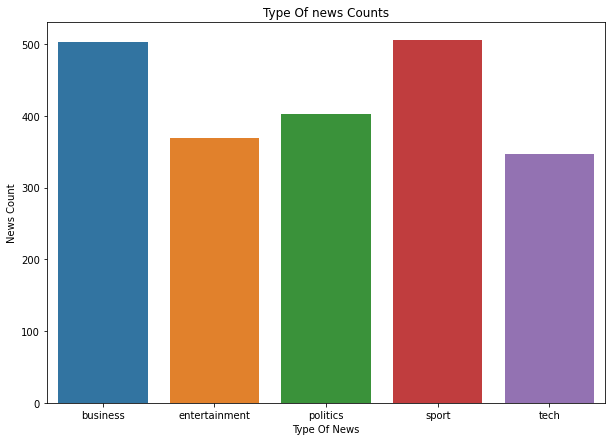

In [335]:
#set figure size
plt.rcParams['figure.figsize'] = [10, 7]

#create a countplot for type in df
sns.countplot(x='type', data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

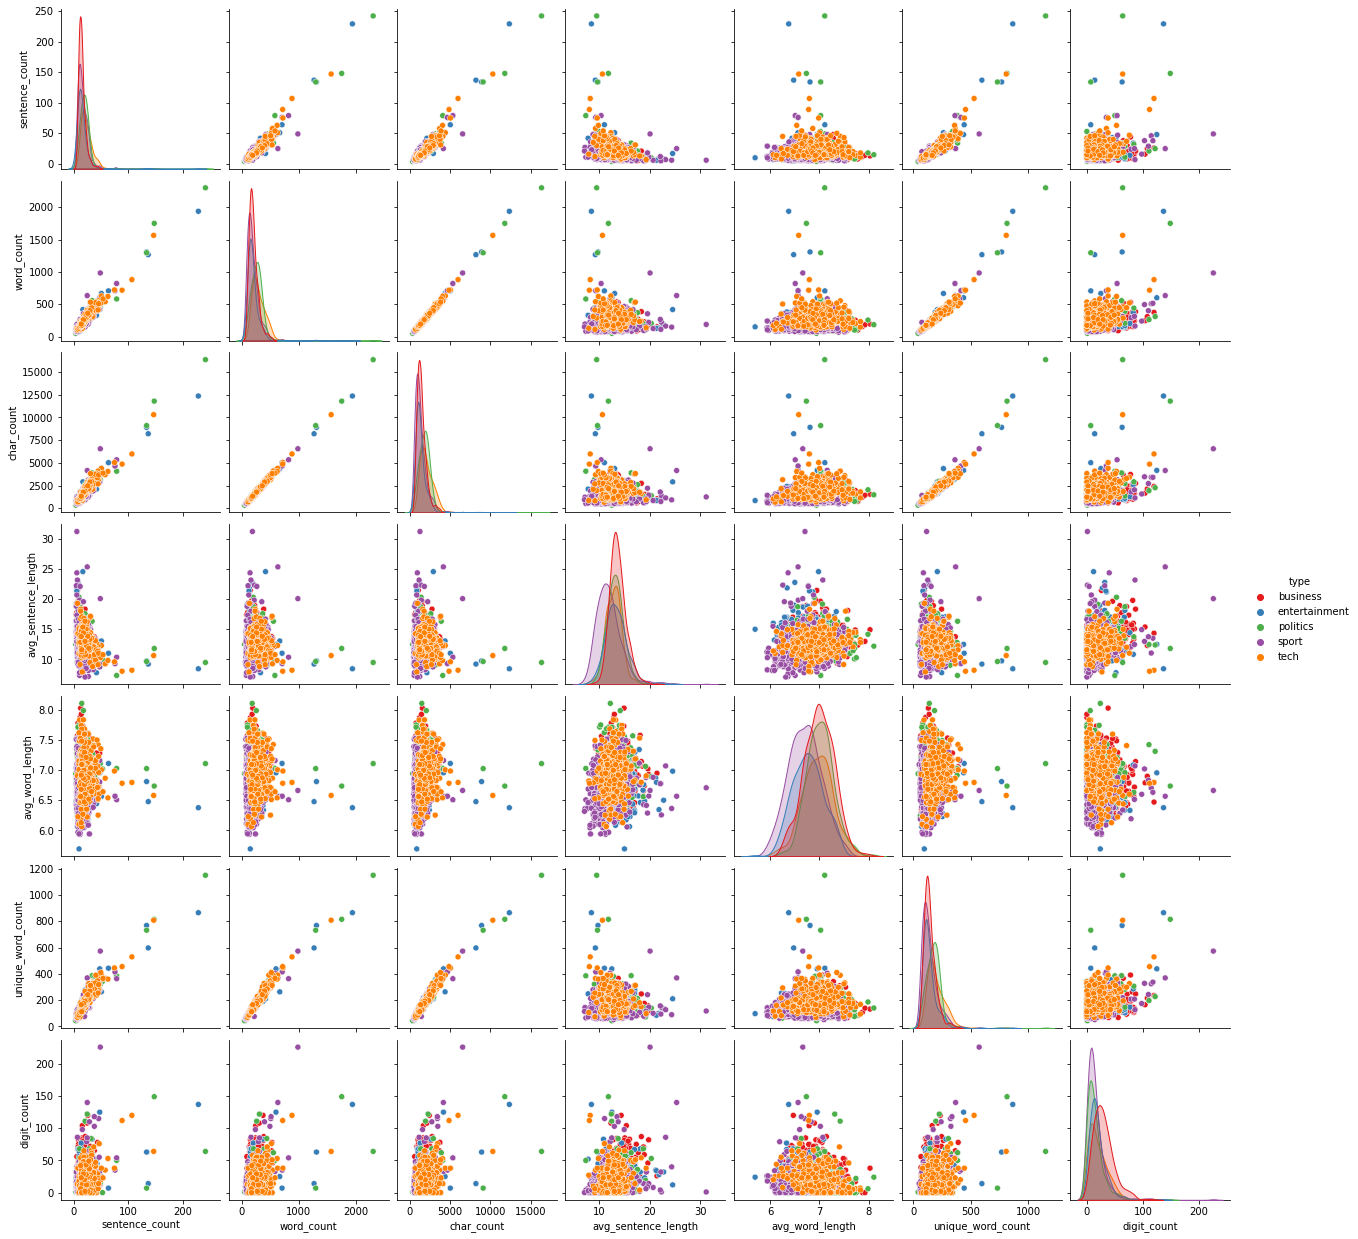

In [336]:
#create pairplot for all the features
sns.pairplot(df, hue='type', palette='Set1')
plt.show()

In [288]:
def group_data(data,topic):
  #group by business type
  business_type = df.groupby('type')

  #get group
  business_grp = business_type.get_group(topic)

  #check data
  business_grp.head()

  #return business type data
  return business_grp

In [339]:
#create a word cloud for popular words in each topic
def word_cloud(data, topic):
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    from matplotlib.offsetbox import AnnotationBbox, OffsetImage
    from PIL import Image
    import nltk
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=stop, max_font_size=40,
                          scale=3, random_state=1).generate(' '.join([i for i in data['text'] if i not in stop]))
    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(topic)
    plt.show()

## **Type Column : business**

In [291]:
business_type = group_data(df,'business')
business_type.head()

text  ... digit_count
0  uk economy end year spurt uk economy grew esti...  ...          41
1  china top trader japan china overtook u become...  ...          84
2  tsunami slows sri lankas growth sri lankas pre...  ...          28
3  million go missing china bank two senior offic...  ...          28
4  lacroix label bought u firm luxury good group ...  ...          10

[5 rows x 9 columns]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


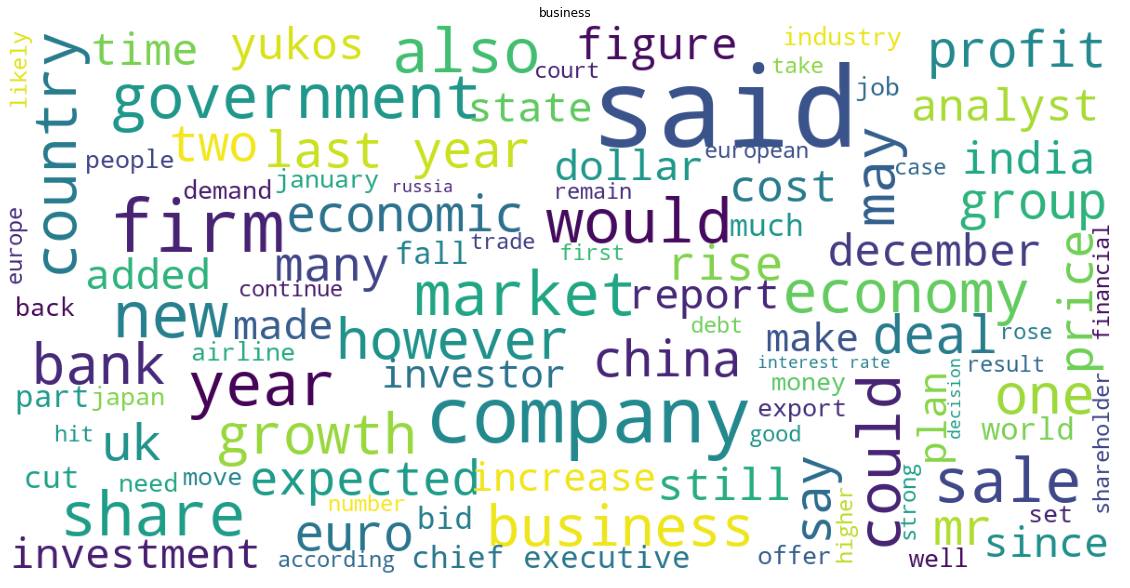

In [340]:
word_cloud(business_type, 'business')

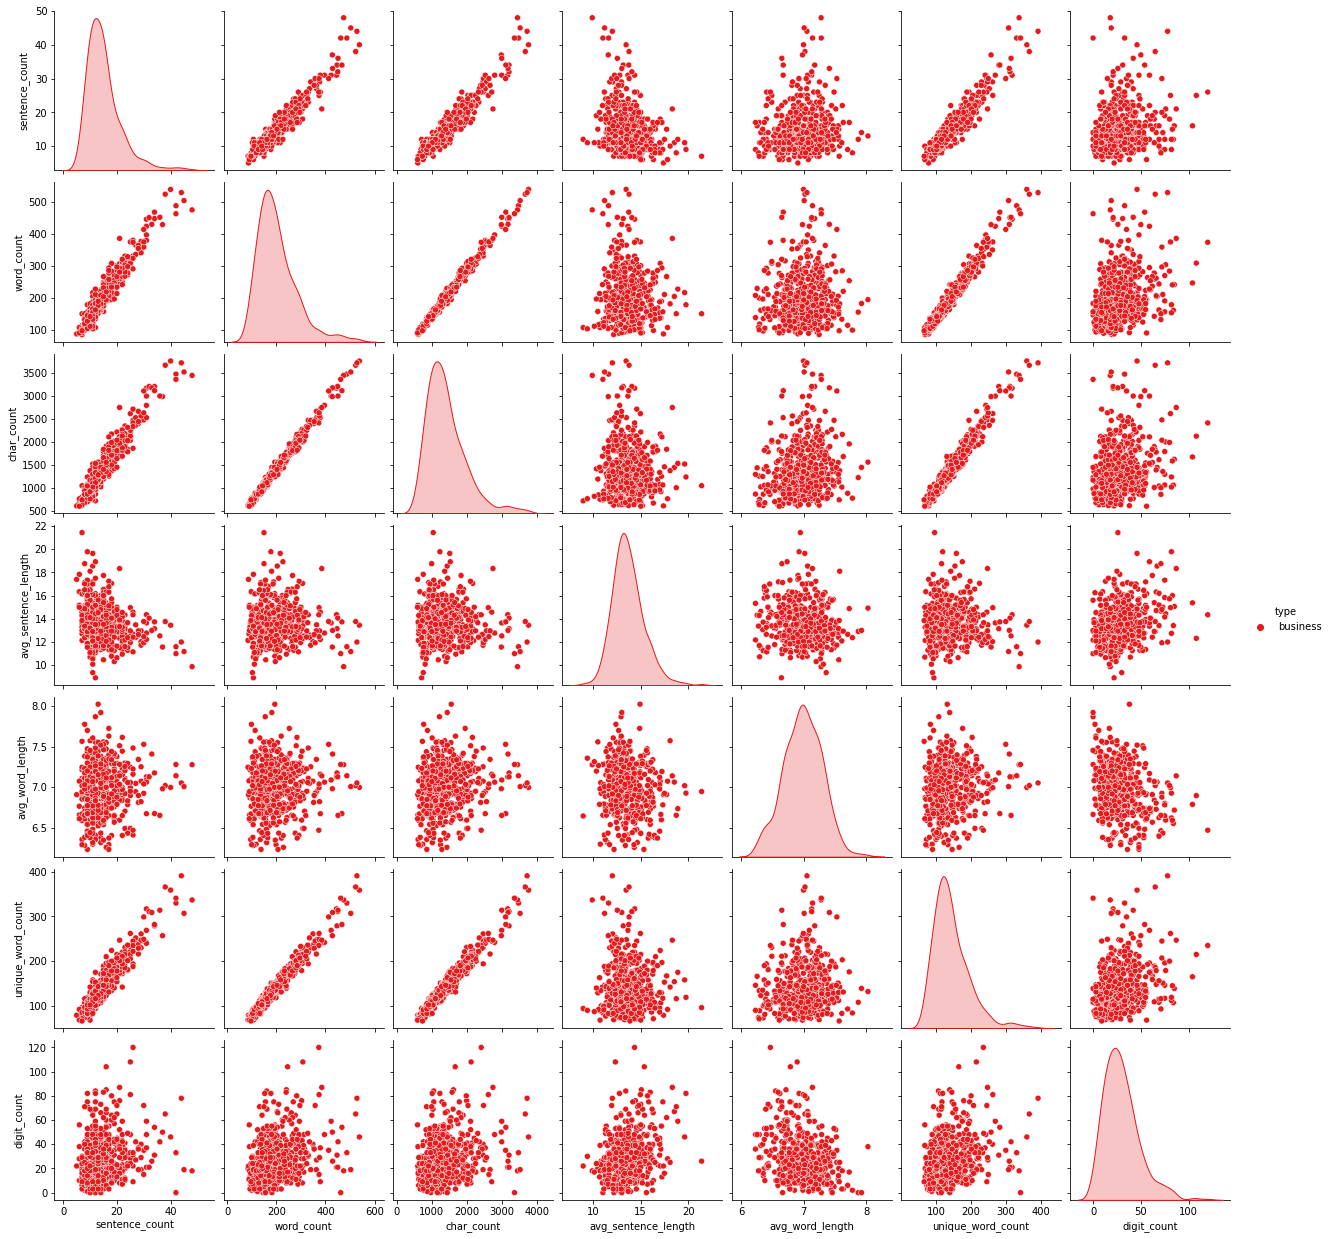

In [341]:
#create pairplot for all the features
sns.pairplot(business_type, hue='type', palette='Set1')
plt.show()

## **Type Column : entertainment**

In [346]:
entertainment_type = group_data(df,'entertainment')
entertainment_type.head()

text  ... digit_count
510  u afflicted award fatigue film world medium ma...  ...          11
511  hitch hold u box office smith first romantic c...  ...          33
512  lost door frontman movie found historian flori...  ...          20
513  shark tale dvd u bestseller oscarnominated ani...  ...          28
514  french honour director parker british film dir...  ...           4

[5 rows x 9 columns]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


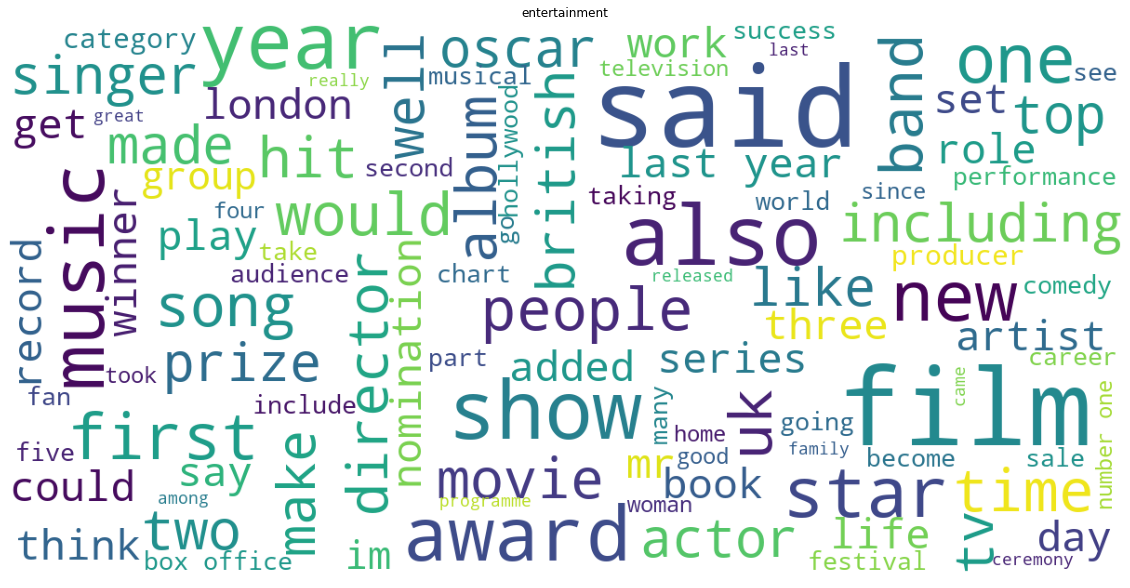

In [347]:
word_cloud(entertainment_type, 'entertainment')

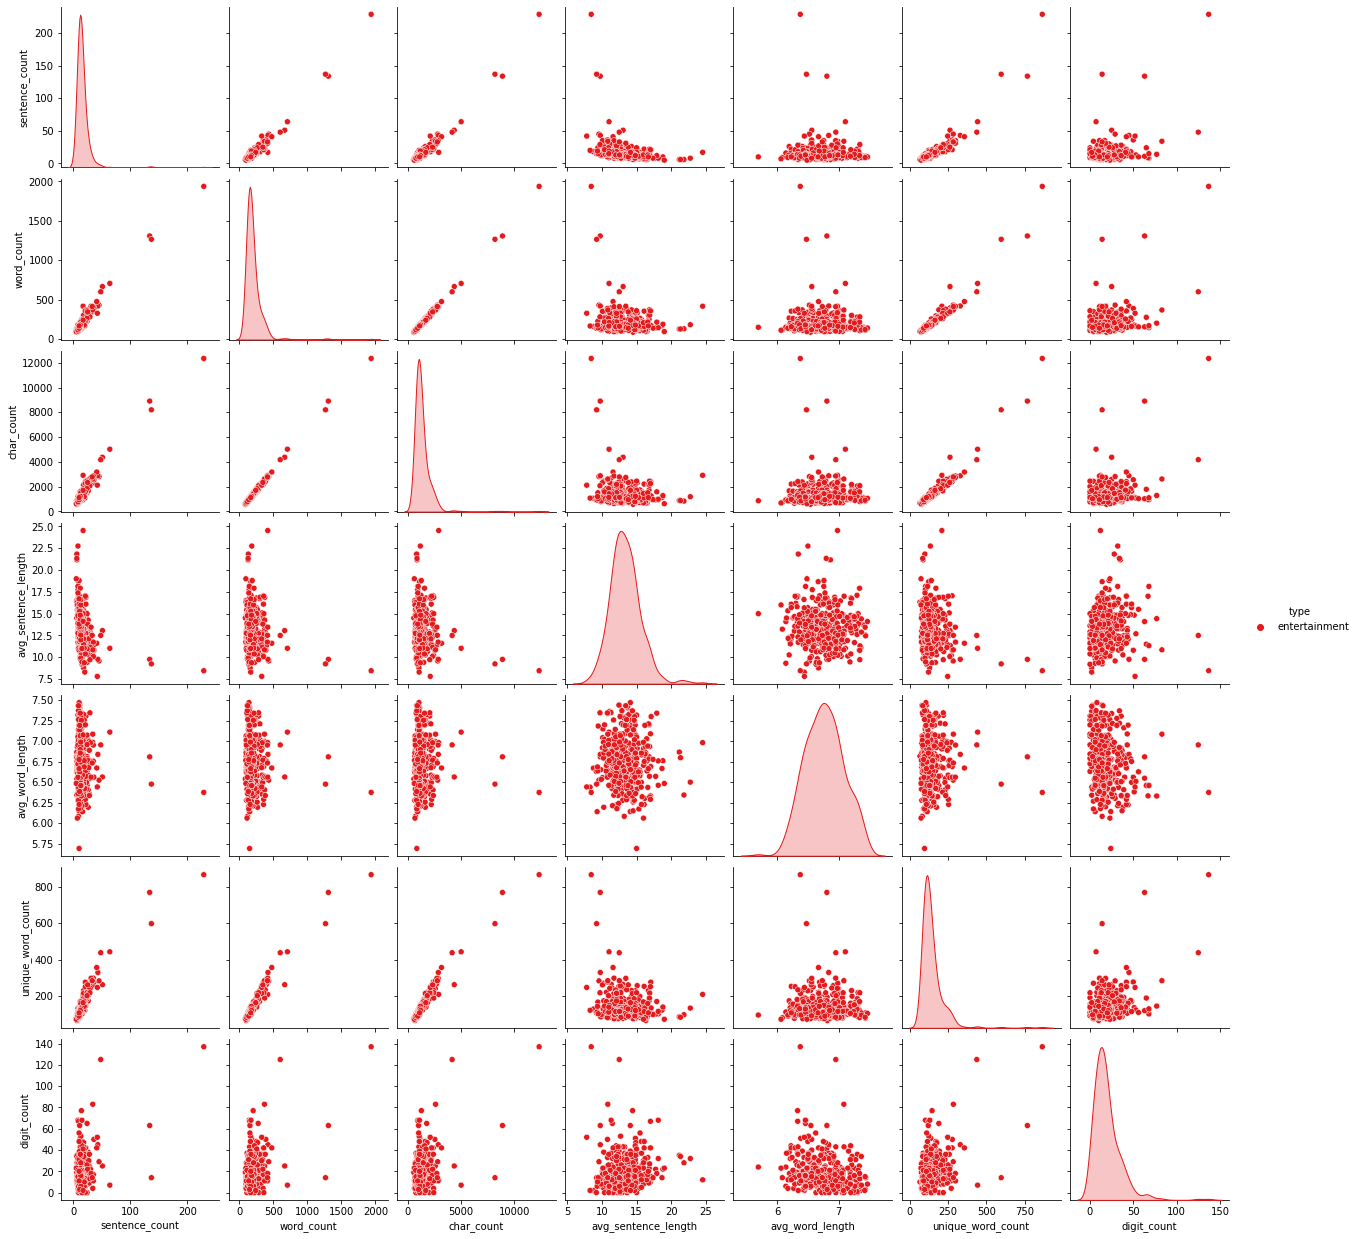

In [348]:
#create pairplot for all the features
sns.pairplot(entertainment_type, hue='type', palette='Set1')
plt.show()

## **Type Column : sport**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


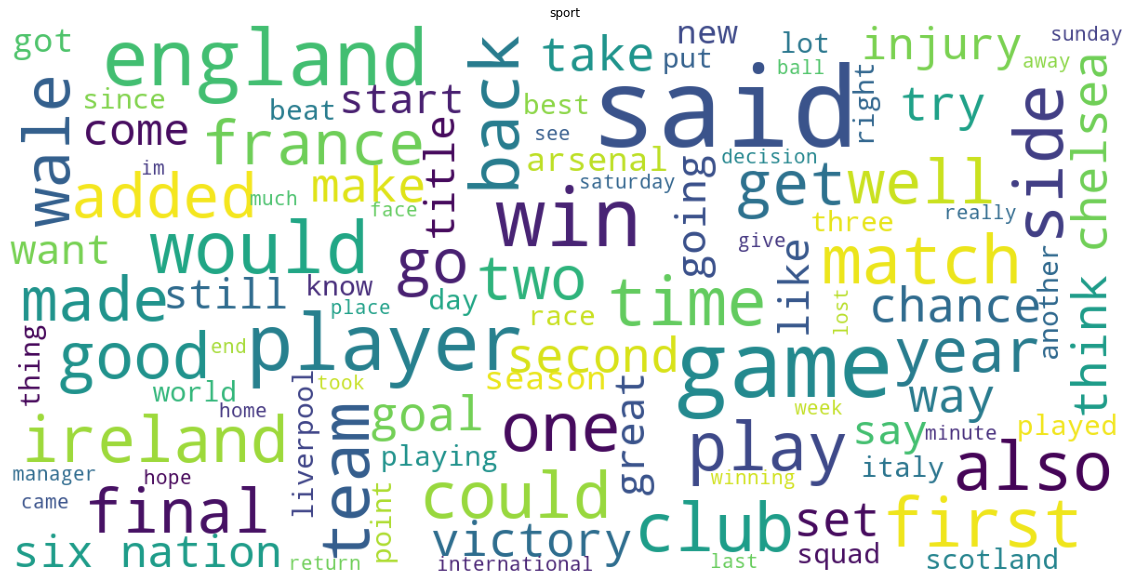

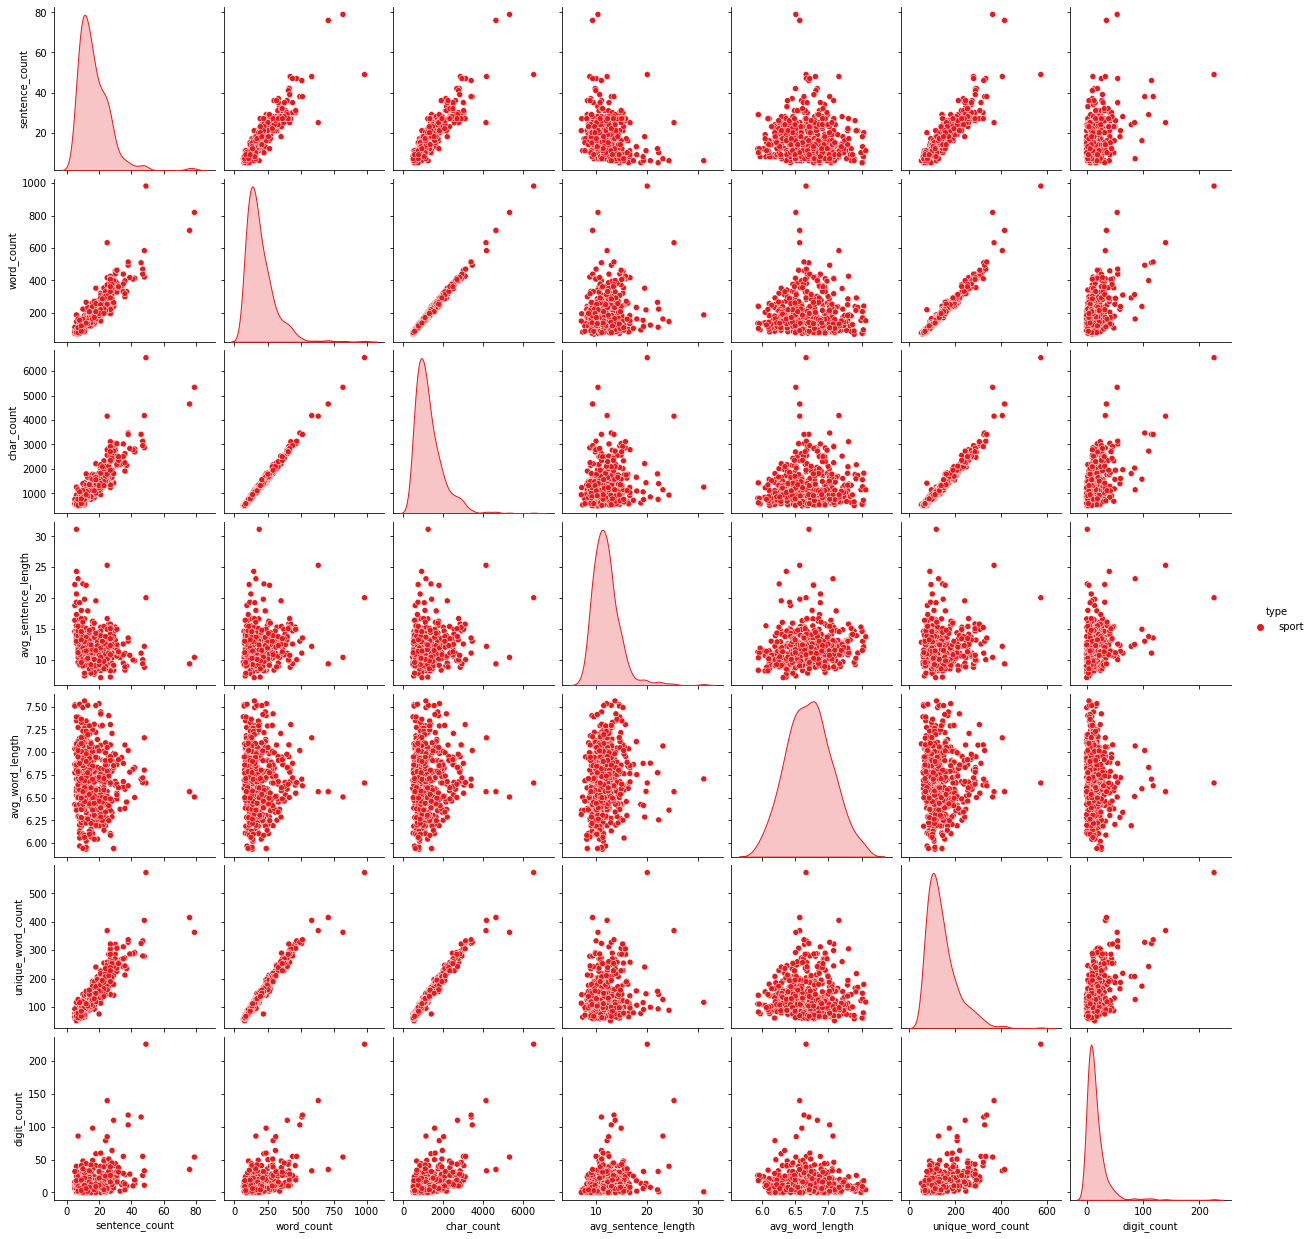

In [352]:
sport_type = group_data(df,'sport')

word_cloud(sport_type, 'sport')

#create pairplot for all the features
sns.pairplot(sport_type, hue='type', palette='Set1')
plt.show()

## **Type Column : politics**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


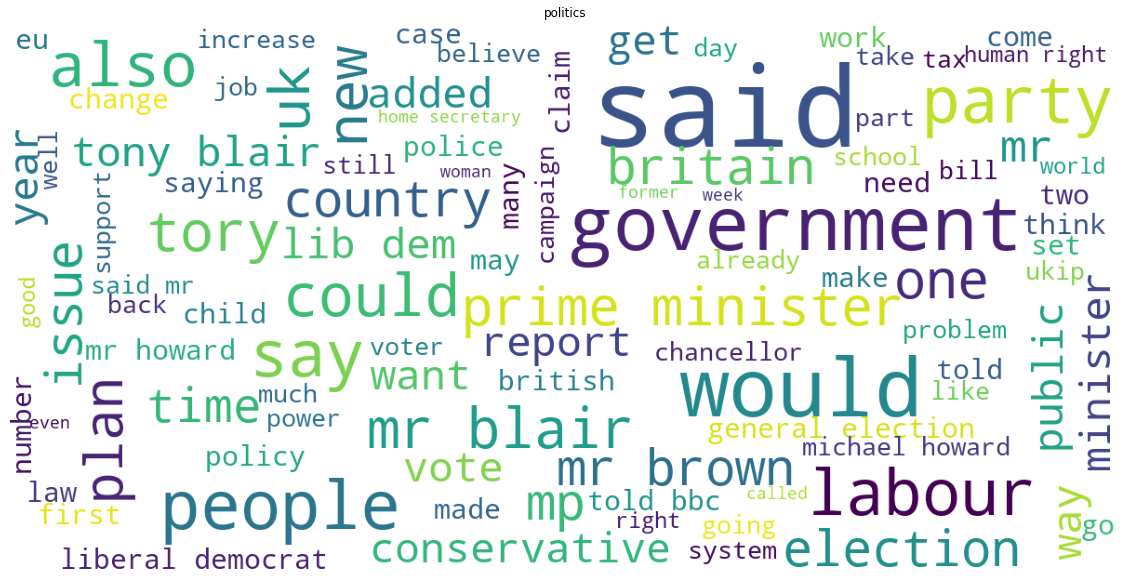

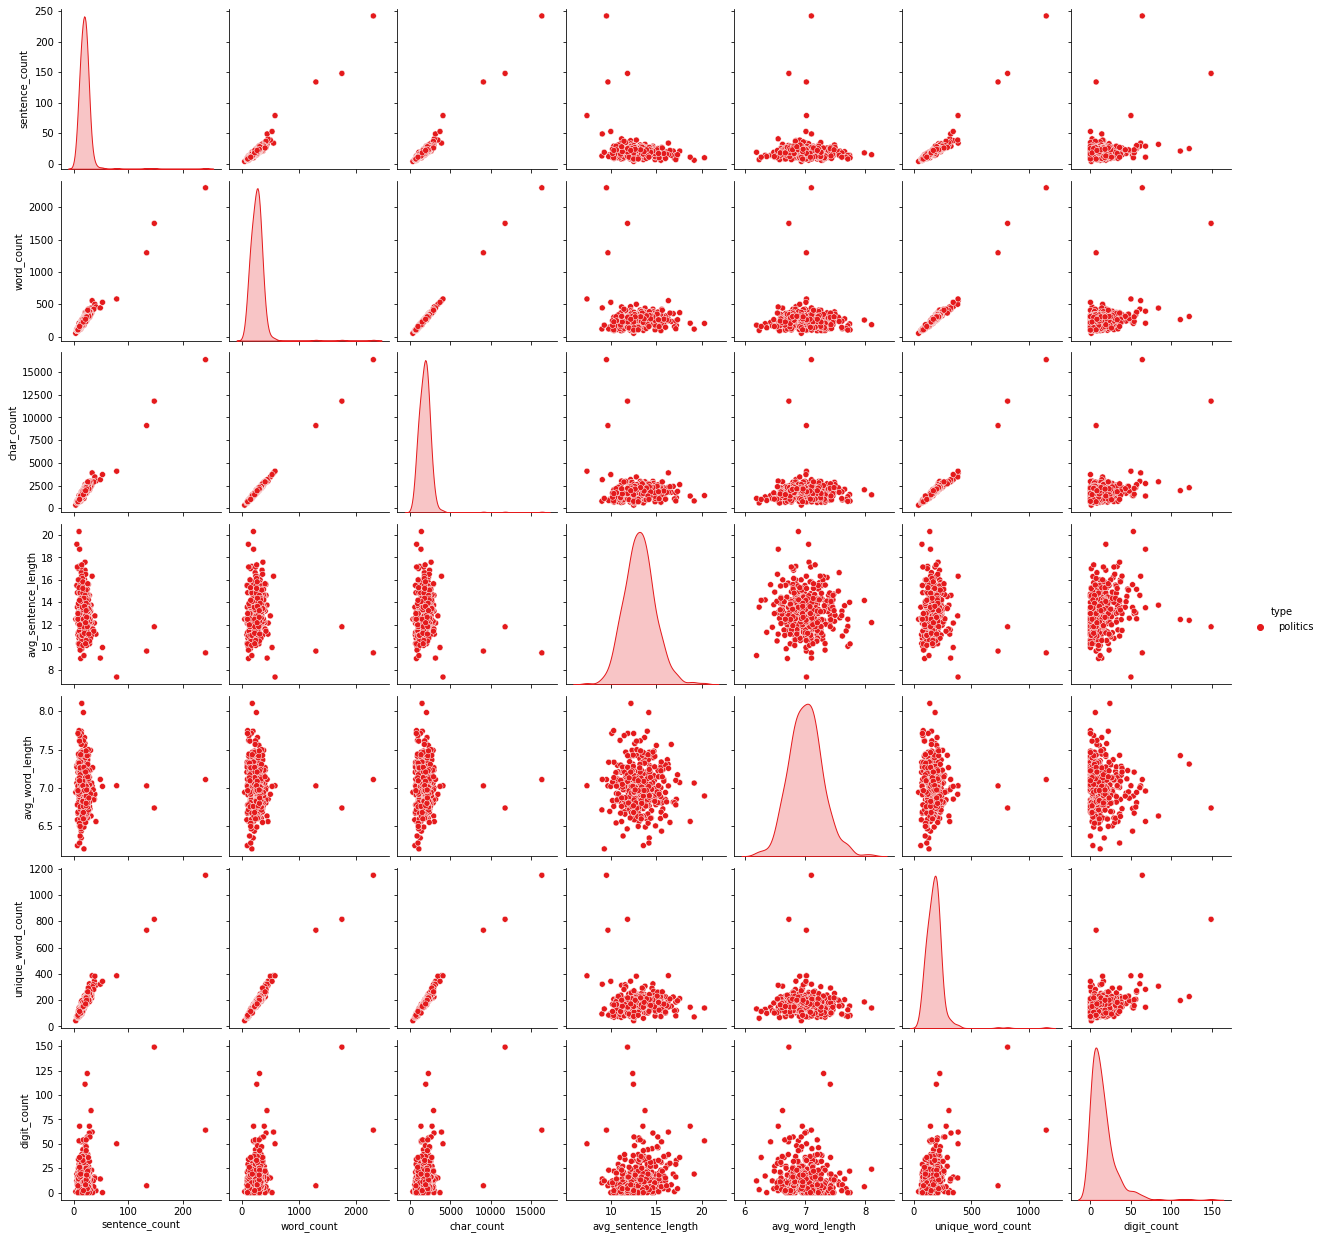

In [360]:
politics_type = group_data(df,'politics')

word_cloud(politics_type, 'politics')

#create pairplot for all the features
sns.pairplot(politics_type, hue='type', palette='Set1')
plt.show()

## **Type Column : tech**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


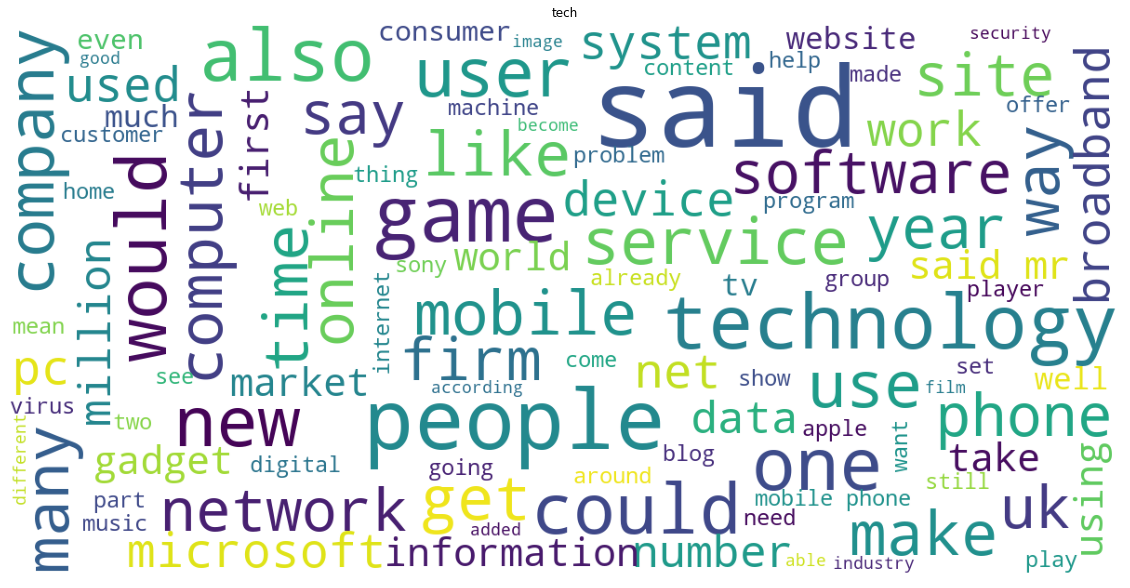

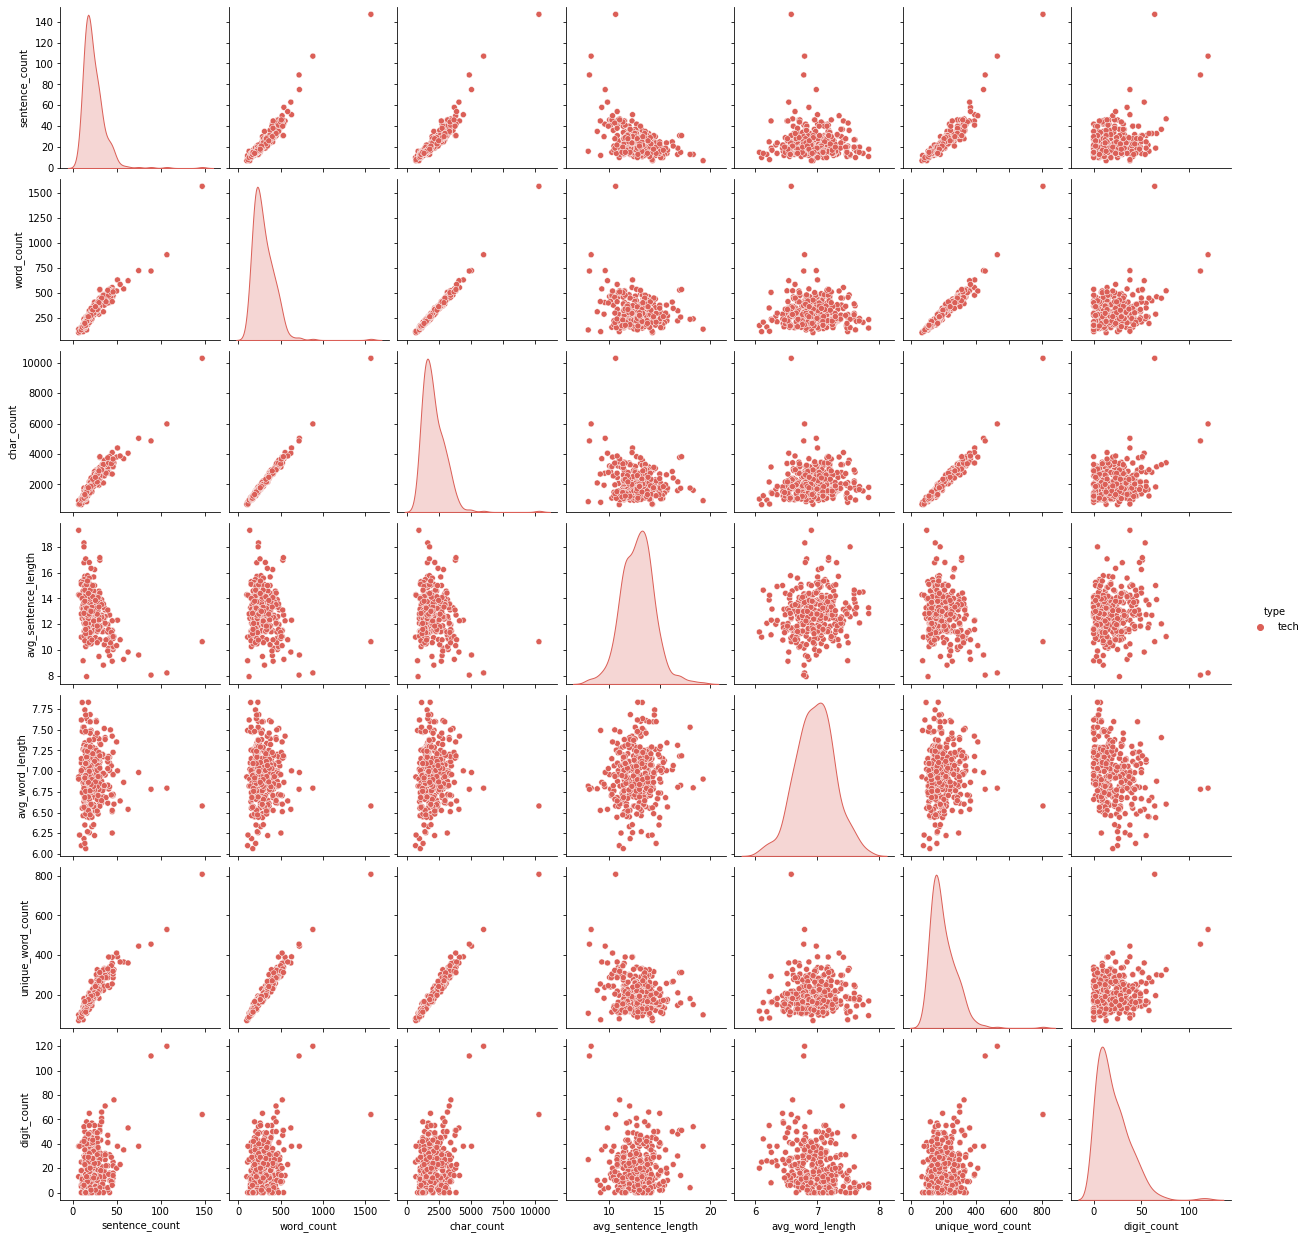

In [361]:
tech_type = group_data(df,'tech')

word_cloud(tech_type, 'tech')

#create pairplot for all the features
sns.pairplot(tech_type, hue='type', palette='hls')
plt.show()

# **Topic Modelling**

1. LDA - Latent Dirichlet Allocation

2. LSA - Latent Semantic Allocation

## **LDA - Latent Dirichlet Allocation**

In [309]:
# Make the dataframe of texts.
lda_data = pd.DataFrame({'text': complete_text})

In [310]:
print(lda_data)

                                                   text
0     UK economy ends year with spurt\n\nThe UK econ...
1     China now top trader with Japan\n\nChina overt...
2     Tsunami slows Sri Lanka's growth\n\nSri Lanka'...
3     Millions go missing at China bank\n\nTwo senio...
4     Lacroix label bought by US firm\n\nLuxury good...
...                                                 ...
2220  Rich pickings for hi-tech thieves\n\nViruses, ...
2221  Piero gives rugby perspective\n\nBBC Sport unv...
2222  Cheaper chip for mobiles\n\nA mobile phone chi...
2223  Yahoo celebrates a decade online\n\nYahoo, one...
2224  Apple iPod family expands market\n\nApple has ...

[2225 rows x 1 columns]


In [311]:
lda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [312]:
# Convert to list
lda_data = lda_data['text'].values.tolist()

In [313]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(lda_data))

print(data_words[:1])

[['uk', 'economy', 'ends', 'year', 'with', 'spurt', 'the', 'uk', 'economy', 'grew', 'by', 'an', 'estimated', 'in', 'after', 'accelerating', 'in', 'the', 'last', 'quarter', 'of', 'the', 'year', 'says', 'the', 'office', 'for', 'national', 'statistics', 'ons', 'the', 'figure', 'is', 'in', 'line', 'with', 'treasury', 'and', 'bank', 'of', 'england', 'forecasts', 'the', 'ons', 'says', 'gross', 'domestic', 'product', 'gdp', 'rose', 'by', 'strong', 'in', 'the', 'three', 'months', 'to', 'december', 'compared', 'with', 'in', 'the', 'previous', 'quarter', 'the', 'rise', 'came', 'despite', 'further', 'decline', 'in', 'production', 'output', 'and', 'the', 'worst', 'christmas', 'for', 'retailers', 'in', 'decades', 'the', 'annual', 'figure', 'marked', 'out', 'the', 'best', 'year', 'since', 'and', 'was', 'also', 'well', 'ahead', 'of', 'the', 'recorded', 'in', 'growth', 'in', 'the', 'final', 'three', 'months', 'of', 'marked', 'the', 'th', 'consecutive', 'quarter', 'of', 'expansion', 'on', 'the', 'basis

In [314]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['economy end year economy grow estimate accelerate last quarter year say office statistic on figure line forecast ons say gross domestic product gdp rise strong month compare previous quarter rise come further decline production output bad retailer decade annual figure mark good year also well ahead record growth final month mark consecutive quarter expansion basis late information enter course continue record period growth say statement ons say service sector account nearly quarter economy grow quarter strong service figure welcome analyst give lacklustre retail sale holiday period fact other service component do so well suggest back trend growth particularly concerned further slowdown say economist financial market however output production sector contract second quarterly fall row state affair economist classify recession however on would comment definition recession manufacturing recovery over chief economist say figure remain odd actually happen ground company may experience toug

In [315]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [316]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.710590655853786 %


In [317]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [318]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2135475.489034568
Perplexity:  1118.4455637395433
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [319]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [320]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -502960.57529449946
Model Perplexity:  1073.3009784989144


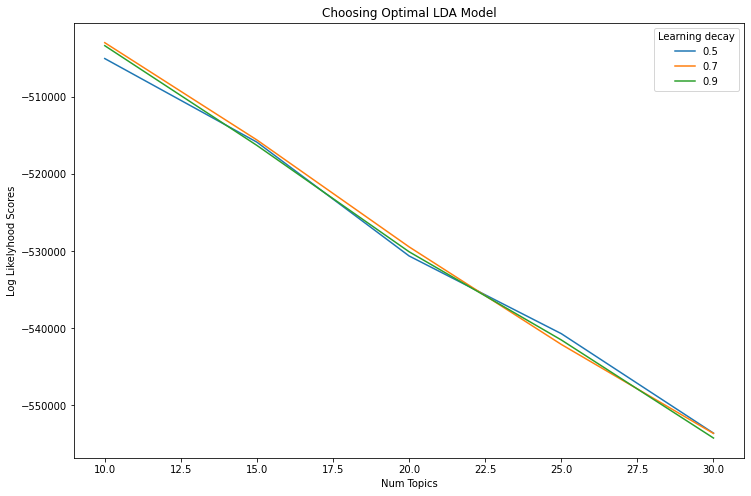

In [321]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [322]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(lda_data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [323]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0          5            481
1          2            348
2          0            300
3          6            297
4          4            242
5          3            156
6          1            151
7          9            123
8          8             65
9          7             62

In [324]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  22.803388
0       0.648955  71.707100       2        1  16.294944
2      71.019684   9.971006       3        1  11.538795
4       3.785981  33.185135       4        1  10.652317
6     -42.666500  -9.222070       5        1   9.965525
3      -3.621689 -43.526516       6        1   8.485096
1      -3.632402  -4.171708       7        1   7.489197
9     -36.584400  35.804413       8        1   5.808659
7      44.391380  50.615383       9        1   3.589673
8      40.235809 -31.591665      10        1   3.372406, topic_info=        Term         Freq        Total Category  logprob  loglift
1255    game  1442.000000  1442.000000  Default  30.0000  30.0000
1156    film  1012.000000  1012.000000  Default  29.0000  29.0000
2134    play  1161.000000  1161.000000  Default  28.0000  28.0000
3312     win  1492.000000  1492.000000  Default  27.0000  27.0000
2136  player   814.000000   814.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
3339   world    53.562121   932.924744  Topic10  -5.2551   0.5321
1099    face    51.195199   509.602847  Topic10  -5.3003   1.0916
1728    lose    50.509248   465.291275  Topic10  -5.3138   1.1690
2530    rise    51.308998   667.774498  Topic10  -5.2981   0.8235
1381    high    49.850248   828.063830  Topic10  -5.3269   0.5795

[692 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
13        5  0.989955   academy
19        6  0.206528  accident
19        9  0.034421  accident
19       10  0.722847  accident
38        5  0.997841     actor
...     ...       ...       ...
3355      8  0.074629      year
3355      9  0.039311      year
3355     10  0.033476      year
3361      8  0.989557   yugansk
3362      8  0.965073     yukos

[2220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 5, 7, 4, 2, 10, 8, 9])

## **LSA - Latent Semantic Allocation**

In [385]:
lsa_df = pd.DataFrame({'Heading' : df['type'],'News': df['text']})

In [386]:
lsa_df.head()

Heading                                               News
0  business  uk economy end year spurt uk economy grew esti...
1  business  china top trader japan china overtook u become...
2  business  tsunami slows sri lankas growth sri lankas pre...
3  business  million go missing china bank two senior offic...
4  business  lacroix label bought u firm luxury good group ...

In [384]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

In [387]:
stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+", 
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(lsa_df['News'])
dtm_mat = dtm.transform(lsa_df['News'])

In [389]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)

In [390]:
s_list = []

for clus in tqdm(range(2,21)):

    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)

    s_list.append(s)

100%|██████████| 19/19 [02:06<00:00,  6.64s/it]


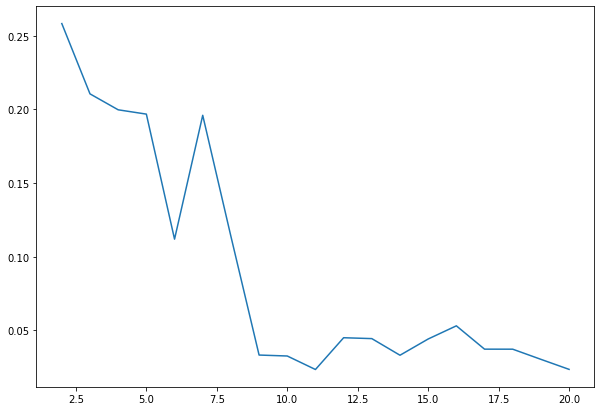

In [391]:
plt.plot(range(2,21), s_list)

plt.show()

From the above graph we can clearly see that topic number=4 has the highest coherence score.

In [392]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


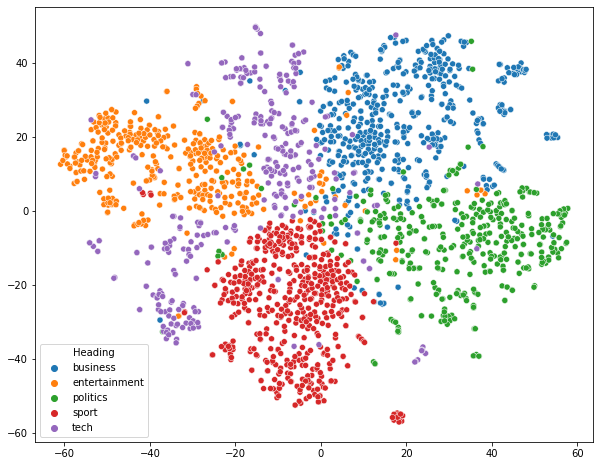

In [394]:
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=lsa_df['Heading'])

In this plot, only the tech-related news article looks like having a much wider spread whereas other news articles look quite nicely clustered. 

# **Conclusion**